# Tuning NN parameters

Data from Kaggle Digit Recognition competition  
https://www.kaggle.com/c/digit-recognizer/data

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


## Load data

In [2]:
!pwd

/Users/zubo/Dropbox/projects/kaggle/digit-recognizer


In [3]:
train_file = 'data/train.csv'
test_file = 'data/test.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [4]:
train_df.head() # labels and pixels

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
test_df.head() # no labels here

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


So each row of the dataset is a sequence of ink intensity for the 784 pixels that represents square image with the size 28x28.

In [6]:
train_labels = train_df.label
train_images = train_df.iloc[:,1:]
test_images = test_df

## Show some digits from the input dataset

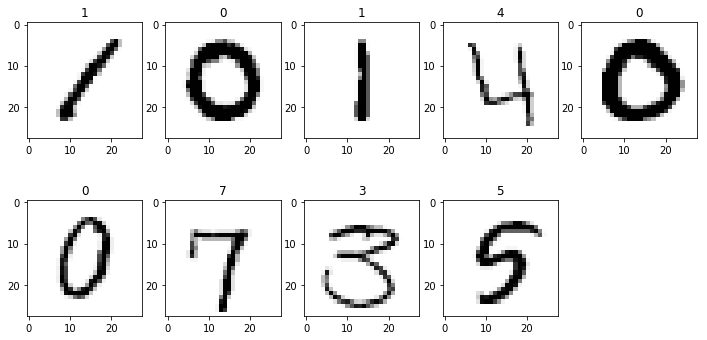

In [7]:
plt.figure(figsize=(12,6))
for i in range(0,9):
    plt.subplot(250 + (i+1))
    img = train_images.ix[i,:].values.reshape(28, 28)
    plt.imshow(img, cmap='Greys')
    plt.title(train_labels[i])

## Preprocess data for NN

In [8]:
train_images = (train_images/train_images.max()).fillna(0) # normalize values
test_images = (test_images/test_images.max()).fillna(0) # normalize values
train_labels = pd.get_dummies(train_labels) # one-hot encoding of the label

In [9]:
train_labels.head()

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


## Tuning hyperparameters for 1-hidden layer dense NN
Some more information about Keras' Sequential models  
https://keras.io/getting-started/sequential-model-guide/

There are different ways to go through selected set of hyperparameters.  
One of them - use Keras models with Scikit-learn wrapper, and then use Scikit-learn capabilities.

In [26]:
nodes = [128, 256, 512, 1024] # number of nodes in the hidden layer
lrs = [0.001, 0.002, 0.003] # learning rate, default = 0.001
epochs = 10
batch_size = 64

In [27]:
# Dense(128*2, input_dim=784),
#     Activation('relu'),
#     Dense(10),
#     Activation('softmax')

def build_model(nodes=10, lr=0.001):
    model = Sequential()
    model.add(Dense(nodes, init='uniform', input_dim=784))
    model.add(Activation('relu'))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    opt = optimizers.RMSprop(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return(model)

In [28]:
model = KerasClassifier(build_fn=build_model, nb_epoch=epochs, batch_size=batch_size, verbose=0)
X = train_images.values
Y = train_labels.values

In [29]:
param_grid = dict(nodes=nodes, lr=lrs)

In [30]:
param_grid

{'lr': [0.001, 0.002, 0.003], 'nodes': [128, 256, 512, 1024]}

In [31]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, pre_dispatch=2, verbose=2)

In [32]:
grid_result = grid.fit(X, Y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] nodes=128, lr=0.001 .............................................
[CV] .............................. nodes=128, lr=0.001, total=  14.3s
[CV] nodes=128, lr=0.001 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s remaining:    0.0s


[CV] .............................. nodes=128, lr=0.001, total=  13.6s
[CV] nodes=128, lr=0.001 .............................................
[CV] .............................. nodes=128, lr=0.001, total=  15.8s
[CV] nodes=256, lr=0.001 .............................................
[CV] .............................. nodes=256, lr=0.001, total=  23.0s
[CV] nodes=256, lr=0.001 .............................................
[CV] .............................. nodes=256, lr=0.001, total=  20.3s
[CV] nodes=256, lr=0.001 .............................................
[CV] .............................. nodes=256, lr=0.001, total=  21.8s
[CV] nodes=512, lr=0.001 .............................................
[CV] .............................. nodes=512, lr=0.001, total=  32.9s
[CV] nodes=512, lr=0.001 .............................................
[CV] .............................. nodes=512, lr=0.001, total=  34.8s
[CV] nodes=512, lr=0.001 .............................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 23.1min finished


In [33]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.975095 using {'nodes': 256, 'lr': 0.003}
0.967952 (0.001285) with: {'nodes': 128, 'lr': 0.001}
0.971833 (0.001750) with: {'nodes': 256, 'lr': 0.001}
0.972333 (0.000560) with: {'nodes': 512, 'lr': 0.001}
0.974905 (0.001352) with: {'nodes': 1024, 'lr': 0.001}
0.971738 (0.000529) with: {'nodes': 128, 'lr': 0.002}
0.970357 (0.003940) with: {'nodes': 256, 'lr': 0.002}
0.973214 (0.001262) with: {'nodes': 512, 'lr': 0.002}
0.973024 (0.003882) with: {'nodes': 1024, 'lr': 0.002}
0.968952 (0.001576) with: {'nodes': 128, 'lr': 0.003}
0.975095 (0.001654) with: {'nodes': 256, 'lr': 0.003}
0.972762 (0.002279) with: {'nodes': 512, 'lr': 0.003}
0.968976 (0.005286) with: {'nodes': 1024, 'lr': 0.003}


In [49]:
acc = grid_result.cv_results_

In [59]:
', '.join(list(acc['params']))

TypeError: sequence item 0: expected str instance, dict found

In [65]:
acc

{'mean_fit_time': array([ 14.03397973,  21.07322439,  32.74237895,  66.66683276,
         19.4633193 ,  24.22747691,  34.4426736 ,  73.3797183 ,
         19.90287566,  25.79622833,  35.80350598,  73.66227444]),
 'mean_score_time': array([ 0.55306729,  0.642404  ,  0.87010201,  1.09922067,  0.70044971,
         0.80031538,  0.93391363,  1.22175177,  0.79184024,  0.88488324,
         1.05658301,  1.35433427]),
 'mean_test_score': array([ 0.96795238,  0.97183333,  0.97233333,  0.97490476,  0.9717381 ,
         0.97035714,  0.97321429,  0.97302381,  0.96895238,  0.97509524,
         0.9727619 ,  0.96897619]),
 'mean_train_score': array([ 0.99336905,  0.99734524,  0.99757143,  0.99880952,  0.99758333,
         0.99627381,  0.9975119 ,  0.99652381,  0.99639286,  0.99802381,
         0.9960119 ,  0.99133333]),
 'param_lr': masked_array(data = [0.001 0.001 0.001 0.001 0.002 0.002 0.002 0.002 0.003 0.003 0.003 0.003],
              mask = [False False False False False False False False False F

In [77]:
[x['lr'] for x in list(acc['params'])]

[0.001,
 0.001,
 0.001,
 0.001,
 0.002,
 0.002,
 0.002,
 0.002,
 0.003,
 0.003,
 0.003,
 0.003]

In [78]:
pd.DataFrame({'lr': [x['lr'] for x in list(acc['params'])],
             'nodes': [x['nodes'] for x in list(acc['params'])]})

,lr,nodes
0,0.001,128
1,0.001,256
2,0.001,512
3,0.001,1024
4,0.002,128
5,0.002,256
6,0.002,512
7,0.002,1024
8,0.003,128
9,0.003,256


In [62]:
acc['params'][1]['lr']

0.001

In [64]:
grid_result.param_grid

{'lr': [0.001, 0.002, 0.003], 'nodes': [128, 256, 512, 1024]}

## Train the model

In [ ]:
# history=model.fit(train_images.values, train_labels.values, validation_split = 0.05, 
#             nb_epoch=15, batch_size=64)

In [67]:
hist_df = pd.DataFrame(history.history)

In [68]:
hist_df.head()

,acc,loss,val_acc,val_loss
0,0.918070,0.289411,0.951429,0.184410
1,0.962607,0.129338,0.964762,0.129029
2,0.973784,0.087557,0.964762,0.123949
3,0.980401,0.065527,0.970000,0.114121
4,0.984787,0.050683,0.968095,0.116065


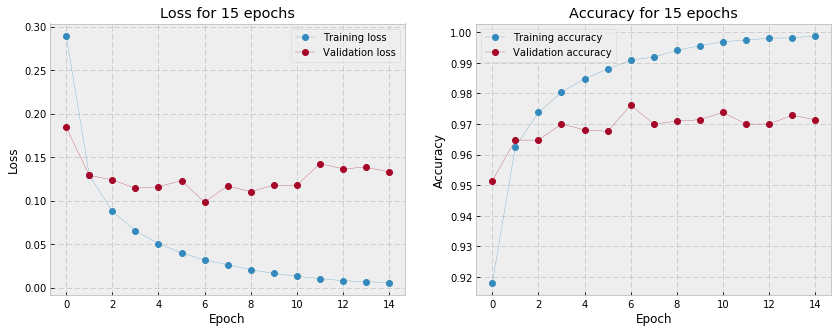

In [69]:
fig = plt.figure(figsize=(14,5))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.acc, label='Training accuracy', **params_dict)
plt.plot(hist_df.val_acc, label='Validation accuracy', **params_dict)
plt.title('Accuracy for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Some conclusions here: 
1. At some number of the epochs (8-10 in this case) the validation loss stops decreasing, i.e. the network begin to overfit. The training loss still decreases.
2. The same is true for the training/validation accuracy - validation accuracy stops increasing after some number of epochs.
3. Since validation data was not used for training, measuring accuracy on the the validation dataset gives us an estimation of the ability of the model to generalize.

Basically we tuned the only one parameter - number of epochs using validation.
Now I will use epochs=10.

In [70]:
# Predict on the whole dataset now, 10 epochs
model = Sequential([
    Dense(256, input_dim=784),
    Activation('relu'),
    Dense(10),
    Activation('softmax')
])

# Multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images.values, train_labels.values, nb_epoch=10, batch_size=64)

Epoch 1/6
42000/42000 [==============================] - 4s - loss: 0.2896 - acc: 0.9159     
Epoch 2/6
42000/42000 [==============================] - 4s - loss: 0.1296 - acc: 0.9621     
Epoch 3/6
42000/42000 [==============================] - 3s - loss: 0.0875 - acc: 0.9747     
Epoch 4/6
42000/42000 [==============================] - 3s - loss: 0.0660 - acc: 0.9810     
Epoch 5/6
42000/42000 [==============================] - 3s - loss: 0.0510 - acc: 0.9850     
Epoch 6/6
42000/42000 [==============================] - 3s - loss: 0.0409 - acc: 0.9881     


## Predict test labels

In [39]:
pred_classes = grid.predict(test_images.values)

In [40]:
pred_classes

array([2, 0, 9, ..., 3, 9, 2])

In [41]:
pred = pd.DataFrame({'ImageId': range(1, len(pred_classes)+1), 'Label': pred_classes})

In [42]:
pred.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3


In [43]:
pred.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [44]:
pred.to_csv('data/output/subm10-256-lr003.csv', index=False)